In [3]:
using Flux, Plots, FFTW, SpecialPolynomials, Distributions, BenchmarkTools
using BSON: @save
include("./data_generation.jl")
include("./utility_functions.jl")

GSA (generic function with 1 method)

In [4]:
# Some global variables.
const nfft = 100    # Grid size
m = 10000     # Number of data points
ft = plan_fft(zeros((nfft,)),flags=FFTW.MEASURE)    # Fourier transform
ift = plan_ifft(zeros((nfft,)),flags=FFTW.MEASURE)  # Inverse Fourier transform

0.01 * FFTW backward plan for 100-element array of ComplexF64
(dft-ct-dit/10
  (dftw-direct-10/72 "t2bv_10_avx2")
  (dft-direct-10-x10 "n2bv_10_avx2"))

Now let's train some neural nets in the supervised way.  The following cells are lifted from models.jl.

In [9]:
#----------------------------------------------------------------------
# Dataset generators

function supervised_dataset(N::Integer,m::Integer)
    # N is grid size, m is number of data points
    field_amps = [randomHGAmplitude(nfft) for i=1:m]
    y_data = [randomConvexPhase(nfft,Cauchy(0,(10^(-0.5-rand()) * pi/nfft))) for i=1:m]
    fft_amps = [abs.(ft*(field_amps[i] .* exp.(im*2*pi*y_data[i]))) for i=1:m]
    x_data_formatted = hcat((vcat(field_amps[i],fft_amps[i]) for i=1:m)...)
    y_data_formatted = hcat(y_data...)
    return x_data_formatted, y_data_formatted
end

function unsupervised_dataset(N::Integer,m::Integer)
    # N is grid size, m is number of data points
    slm_amps = [randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1 : 0.01)) for i=1:m]
    cam_amps = [randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1 : 0.1)) for i=1:m]
    return hcat( (vcat(slm_amps[i],cam_amps[i]) for i=1:m)... )
end

function format_conv_data(data)
    # Reshapes 1D data into the format required for convolutional layers. 
    return convert.(Float32,reshape(data,size(data)[1],1,size(data)[2]))
end

#----------------------------------------------------------------------
# Training loop

function train_and_monitor!(loss,model,batched_data,learning_rate,nit,xs,ys,interval=1)
    ls = []    # Loss, recorded every `interval` iterations. 
    for i=1:nit
        Flux.train!(loss,Flux.params(model),batched_data,Flux.Optimise.Adam(learning_rate))
        (i-1) % interval == 0 && append!(ls,loss(xs,ys))
    end
    return ls
end

train_and_monitor! (generic function with 2 methods)

In [10]:
# Baseline model
nHidden = 400
sMLP1 = Chain(Dense(2*nfft,nHidden,relu),Dense(nHidden,nHidden,relu),Dense(nHidden,nHidden,relu),
    Dense(nHidden,nHidden,relu),Dense(nHidden,nHidden,relu), Dense(nHidden,nfft))
loss_sMLP1(x,y) = Flux.Losses.mse(sMLP1(x),y)
data_x,data_y = supervised_dataset(nfft,m)
batched_data_sMLP1 = Flux.Data.DataLoader((data_x,data_y),batchsize=64)
ls1 = train_and_monitor!(loss_sMLP1,sMLP1,batched_data_sMLP1,0.001,100,data_x,data_y,1);

100-element Vector{Any}:
 270183.58738851844
 270725.6126239576
 270904.93539284205
 270200.793247567
 269931.53381830244
 269305.38260522665
 269459.4870109045
 269530.05808472715
 268982.68827322475
 269210.7116763023
 269353.3732992662
 268927.8640928186
 268862.7672723724
      ⋮
 263296.3600324227
  93647.80883584547
 148311.55680458515
 109873.10676999755
 185047.92481571258
 168833.53860939824
 139361.8383324167
 263726.3609731471
 189497.11335355337
 212099.89124651183
 231628.2791284793
 138589.75120234746

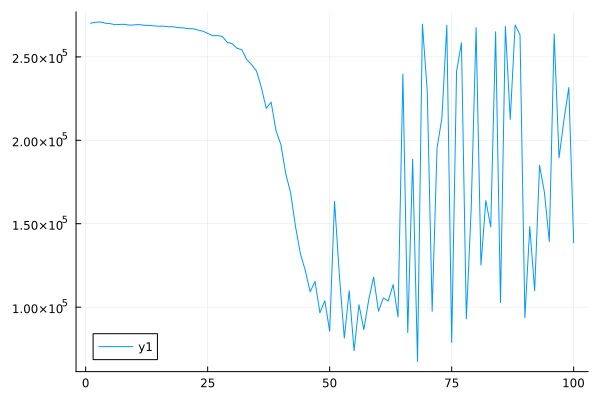

In [11]:
plot(ls1)

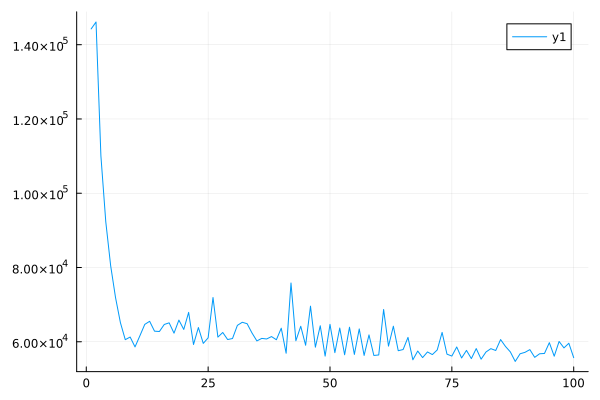

In [12]:
ls2 = train_and_monitor!(loss_sMLP1,sMLP1,batched_data_sMLP1,0.0002,100,data_x,data_y,1);
plot(ls2)

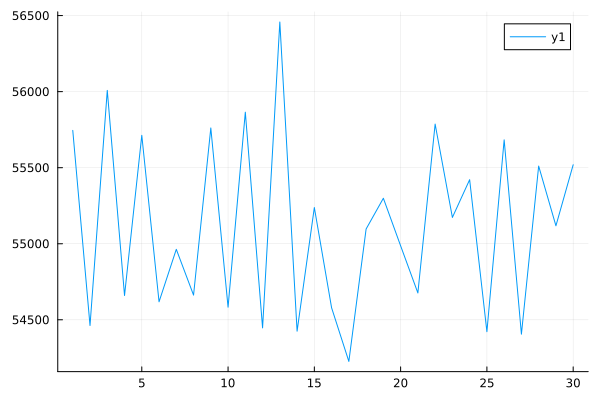

In [14]:
ls3 = train_and_monitor!(loss_sMLP1,sMLP1,batched_data_sMLP1,0.0001,30,data_x,data_y,1);
plot(ls3)

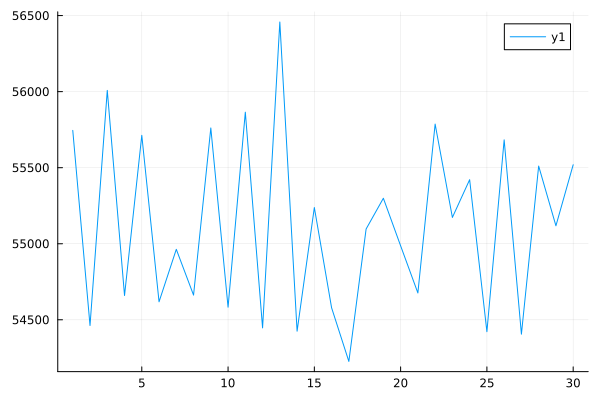

In [22]:
ls4 = train_and_monitor!(loss_sMLP1,sMLP1,batched_data_sMLP1,0.00002,30,data_x,data_y,1);
plot(ls3)

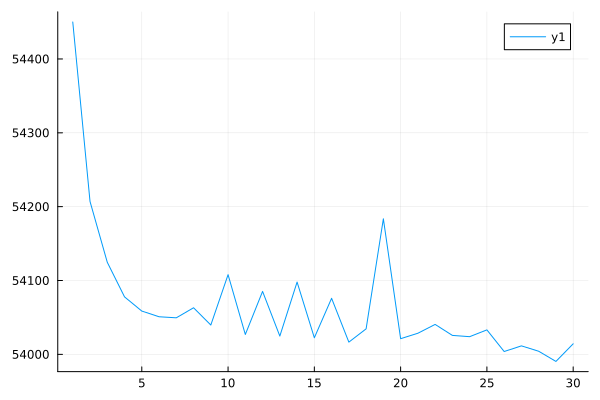

In [23]:
plot(ls4)

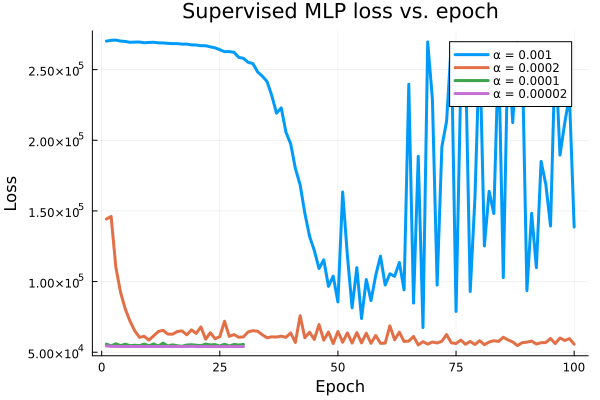

In [24]:
# Summarize training
plot([ls1[1:100], ls2[1:100], ls3,ls4], title="Supervised MLP loss vs. epoch", labels=["α = 0.001" "α = 0.0002" "α = 0.0001" "α = 0.00002"], xlabel="Epoch", ylabel="Loss", linewidth=3)

In [26]:
# Save the model
@save "sMLP1.bson" sMLP1

In [31]:
# Get the metric performance of the model
err = []
for i=1:1000
    ampIn = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.01))
    ampOut = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.1))
    phi = sMLP1(vcat(ampIn,ampOut))
    append!(err,PRerror(ampIn,ampOut,phi,ft))
end
mean(err),std(err)

(0.8964648183286971, 0.15682116169558324)

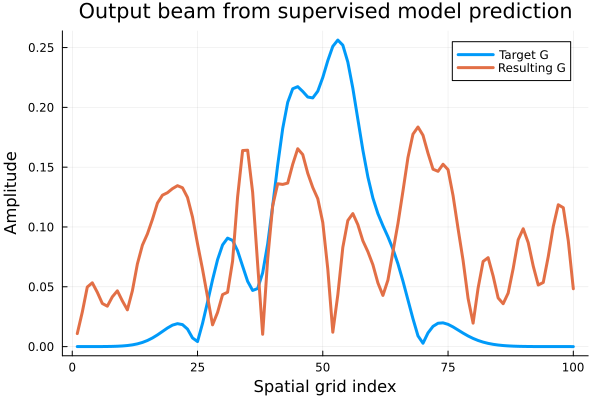

In [39]:
ampIn = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.01))
ampOut = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.1))
phi = sMLP1(vcat(ampIn,ampOut))
plot([ampOut,abs.(ft*(ampIn .* exp.(2*pi*im*phi))/10)],labels=["Target G" "Resulting G"], linewidth=3, xlabel="Spatial grid index", ylabel="Amplitude",title="Output beam from supervised model prediction")

In [29]:
# Time the model
@benchmark sMLP1(vcat(ampIn,ampOut))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  107.868 μs …   8.645 ms  ┊ GC (min … max): 0.00% … 98.50%
 Time  (median):     115.079 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   127.358 μs ± 121.465 μs  ┊ GC (mean ± σ):  1.31% ±  1.39%

  ▆██▇▆▃▃▃▃▃▃▃▂▁▂▃▃▂▁  ▁ ▁    ▁                                 ▂
  █████████████████████████████████▇▇█▇▇▇▇▇▆▇▇▇▆▇▆▅▆▇▆▅▆▄▇▆▅▆▄▅ █
  108 μs        Histogram: log(frequency) by time        244 μs <

 Memory estimate: 36.02 KiB, allocs estimate: 13.

Now we train a CNN, using the same supervised learning approach. 

In [33]:
# CNN
sCNN1 = Chain(Conv((5,), 1 => 8, relu; pad = SamePad()),Conv((5,), 8 => 16, relu; pad = SamePad()),MaxPool((4,)),
    Conv((5,), 16 => 32, relu; pad = SamePad()),Conv((5,), 32 => 64, relu; pad = SamePad()),MaxPool((5,)),
    Flux.flatten,Dense(640,640,relu),Dense(10*64,100))
loss_sCNN1(x,y) = Flux.Losses.mse(sCNN1(x),y)
# data_x,data_y = supervised_dataset(nfft,m)
data_x_conv = format_conv_data(data_x)
batched_data_sCNN1 = Flux.Data.DataLoader((data_x_conv,data_y),batchsize=64)
lsCNN1 = train_and_monitor!(loss_sCNN1,sCNN1,batched_data_sCNN1,0.001,100,data_x_conv,data_y,1)

100-element Vector{Any}:
 270777.9580932413
 270457.52545095194
 270269.09296671767
 270034.74257206934
 269893.12701750814
 269754.5031533216
 269615.39725274174
 269530.9849339944
 269368.4428653557
 269315.2590752074
 269119.7309814091
 268944.6579929156
 268763.24361234193
      ⋮
  60593.71226693324
  57512.132453446
 170175.29158550993
  65642.8998774131
  51006.0622848187
  84496.68205616715
  49611.55996806876
  67588.64639459744
  90962.19482961878
  55536.93790598807
  58372.47140779876
  93764.57150104786

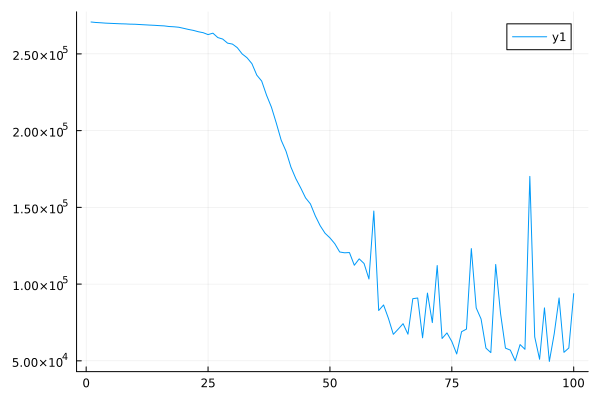

In [40]:
plot(lsCNN1)

In [41]:
lsCNN1 = train_and_monitor!(loss_sCNN1,sCNN1,batched_data_sCNN1,0.0002,30,data_x_conv,data_y,1)

30-element Vector{Any}:
 54446.11496695451
 47786.92757292825
 46092.083463526615
 45942.2254402058
 47334.84817613589
 45592.21095331515
 46705.96255619445
 46691.57416691768
 45648.86051463985
 46171.46134675508
 45789.81669520544
 45859.79806245497
 45362.0890316589
     ⋮
 45173.25606033366
 45457.575532132105
 45141.60139710278
 45390.77616356538
 45092.92307762416
 45350.200605204496
 45084.444806385894
 45227.63643808264
 45087.403295831406
 45094.63856012401
 45102.54773550312
 44990.459170711474

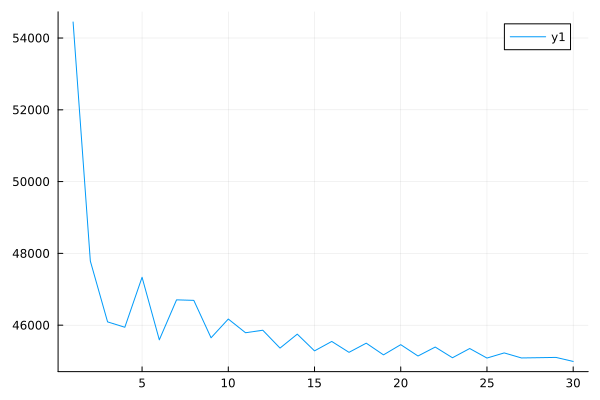

In [42]:
plot(lsCNN1)

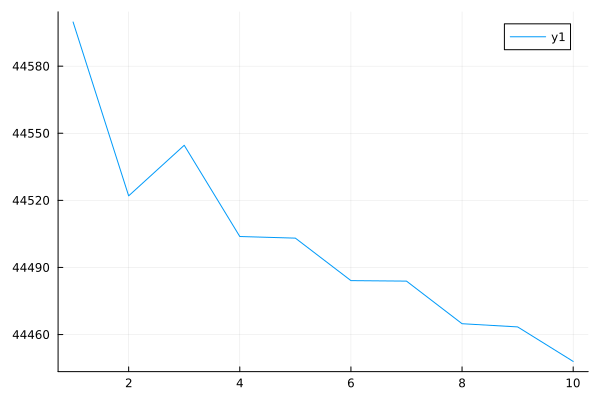

In [43]:
lsCNN1 = train_and_monitor!(loss_sCNN1,sCNN1,batched_data_sCNN1,0.00005,10,data_x_conv,data_y,1)
plot(lsCNN1)

In [44]:
# Get the metric performance of the model
err2 = []
for i=1:1000
    ampIn = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.01))
    ampOut = randomHGAmplitude(nfft,Normal(),x-> (x==0 ? 1.0 : 0.1))
    phi = convert.(Float64,sCNN1(convert.(Float32,reshape(vcat(ampIn,ampOut),2nfft,1,1)))[:,1])
    append!(err2,PRerror(ampIn,ampOut,phi,ft))
end
mean(err2),std(err2)

(1.0440934144046354, 0.18175492053951992)

In [45]:
@save "sCNN1.bson" sCNN1